In [1]:
import torch
import timm
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch
import torch.optim as optim
import os
import random
import shutil
from torchvision import datasets
from csvlogger import CSVLogger
import pandas as pd
import matplotlib.pyplot as plt
import datetime

KeyboardInterrupt: 

In [ ]:
avail_pretrained_models = timm.list_models(pretrained=True)
print(avail_pretrained_models)

['bat_resnext26ts.ch_in1k', 'beit_base_patch16_224.in22k_ft_in22k', 'beit_base_patch16_224.in22k_ft_in22k_in1k', 'beit_base_patch16_384.in22k_ft_in22k_in1k', 'beit_large_patch16_224.in22k_ft_in22k', 'beit_large_patch16_224.in22k_ft_in22k_in1k', 'beit_large_patch16_384.in22k_ft_in22k_in1k', 'beit_large_patch16_512.in22k_ft_in22k_in1k', 'beitv2_base_patch16_224.in1k_ft_in1k', 'beitv2_base_patch16_224.in1k_ft_in22k', 'beitv2_base_patch16_224.in1k_ft_in22k_in1k', 'beitv2_large_patch16_224.in1k_ft_in1k', 'beitv2_large_patch16_224.in1k_ft_in22k', 'beitv2_large_patch16_224.in1k_ft_in22k_in1k', 'botnet26t_256.c1_in1k', 'caformer_b36.sail_in1k', 'caformer_b36.sail_in1k_384', 'caformer_b36.sail_in22k', 'caformer_b36.sail_in22k_ft_in1k', 'caformer_b36.sail_in22k_ft_in1k_384', 'caformer_m36.sail_in1k', 'caformer_m36.sail_in1k_384', 'caformer_m36.sail_in22k', 'caformer_m36.sail_in22k_ft_in1k', 'caformer_m36.sail_in22k_ft_in1k_384', 'caformer_s18.sail_in1k', 'caformer_s18.sail_in1k_384', 'caformer_s

In [ ]:
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
 
# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device: {torch.cuda.current_device()}")
       
print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")

Is CUDA supported by this system? True
CUDA version: 11.8
ID of current CUDA device: 0
Name of current CUDA device: NVIDIA GeForce RTX 3060 Laptop GPU


In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Device: {device}")

Device: cuda


In [ ]:
print(os.listdir('Binary_ttv\\src')) # Preliminary Image Processing\Alzheimer_s Dataset_binary\src
print(os.listdir('Binary_ttv\\train'))
print(os.listdir('Binary_ttv\\test'))
print(os.listdir('Binary_ttv\\val'))

['Demented', 'NonDemented']
['Demented', 'NonDemented']
['Demented', 'NonDemented']
['Demented', 'NonDemented']


In [ ]:
# Define transformations for image preprocessing
transform = transforms.Compose([
    transforms.Resize((176, 208)),  # Resize images to a common size (adjust as needed)
    transforms.ToTensor(),           # Convert images to tensors
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),  # Normalize using ImageNet stats
])

# Load training and testing datasets
train_dataset = ImageFolder(root='Binary_ttv\\train', transform=transform)
test_dataset = ImageFolder(root='Binary_ttv\\test', transform=transform)
val_dataset = ImageFolder(root='Binary_ttv\\val', transform=transform)

batch_size = 26  # Adjust as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

print(len(train_loader))
print(len(test_loader))
print(len(val_loader))
print(len(train_dataset))
print(len(test_dataset))
print(len(val_dataset))

3661
776
499
95165
20170
12967


In [ ]:
learning_rate = 0.0001
epochs = 100
patience = 5

Resnet50

In [ ]:
model = timm.create_model('resnet50', pretrained=True, num_classes=2, drop_rate=0.2).to(device)

losslogger = CSVLogger('resnet50_loss.csv', fieldnames=["datetime", "batch", "epoch", "train_loss", "val_loss", "val_accuracy"])
acclogger = CSVLogger('resnet50_acc.csv', fieldnames=["datetime", "average_accuracy"])
loss_value = torch.nn.CrossEntropyLoss()

model_opt = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# Training loop
num_epochs = epochs  
early_stopping = False  
best_loss = float('inf') 
counter = 0

print(f"Device: {device}")

print(f"Start time: {datetime.datetime.now()}")


for epoch in range(num_epochs):
    model.train()  
    # Training
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        model_opt.zero_grad()
        outputs = model(inputs)
        loss = loss_value(outputs, labels)
        loss.backward()
        model_opt.step()
        counter += 1
        if counter % 1800 == 0:
            print(f"Completed {counter} batches")
    
    # Validation
    model.eval()  
    total = 0
    correct = 0
    val_loss = 0.0
    for val_inputs, val_labels in val_loader:
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss += loss_value(val_outputs, val_labels).item()
        _, predicted = torch.max(val_outputs.data, 1)
        total += val_labels.size(0)
        correct += (predicted == val_labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    losslog_data = {"datetime": datetime.datetime.now(), "batch": batch_size, "epoch": epoch+1, "train_loss": loss.item(), "val_loss": val_loss, "val_accuracy": val_accuracy}
    losslogger.log(losslog_data)

    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0  
    else:
        patience_counter += 1  
        
        # If validation loss hasn't improved for 'patience' epochs, stop early
        if patience_counter >= patience:
            print("Early stopping triggered")
            early_stopping = True
            break
    
    if early_stopping:
        break
    
    print(f"Completed epoch {epoch + 1} with loss {loss.item()}, validation loss {val_loss}")

# -----------------------------------------

correct = 0
total = 0
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
acclog_data = {"datetime": datetime.datetime.now(), "average_accuracy": accuracy}
acclogger.log(acclog_data)
print('\n\nAccuracy on the test dataset: {:.6f}%'.format(accuracy), end="\n\n")

# -----------------------------------------


torch.save(model.state_dict(), 'resnet50.pth')

Device: cuda
Start time: 2023-11-04 23:07:44.892375
Completed 1800 batches
Completed 3600 batches
Completed epoch 1 with loss 0.6036391854286194, validation loss 0.4329794845235849
Completed 5400 batches
Completed 7200 batches
Completed epoch 2 with loss 0.3055563271045685, validation loss 0.3826148519311138
Completed 9000 batches
Completed 10800 batches
Completed epoch 3 with loss 0.15706248581409454, validation loss 0.3577156418408146
Completed 12600 batches
Completed 14400 batches
Completed epoch 4 with loss 0.48578959703445435, validation loss 0.34001256040444894
Completed 16200 batches
Completed 18000 batches
Completed epoch 5 with loss 0.5785778760910034, validation loss 0.3201413854008507
Completed 19800 batches
Completed 21600 batches
Completed epoch 6 with loss 0.13252775371074677, validation loss 0.3205596915313709
Completed 23400 batches
Completed 25200 batches
Completed epoch 7 with loss 0.4802648425102234, validation loss 0.30507203706452446
Completed 27000 batches
Complet

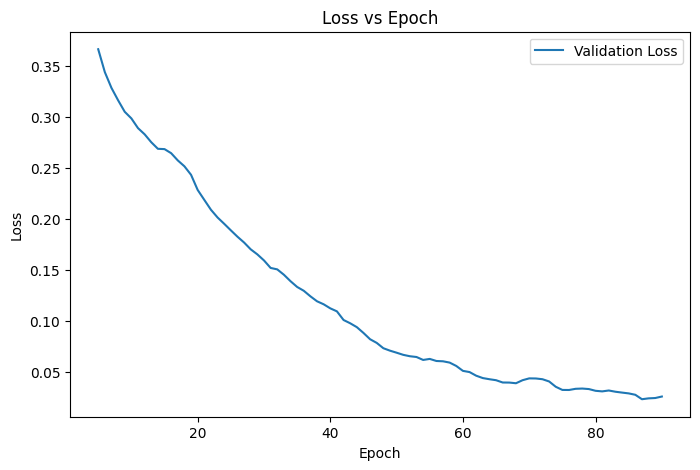

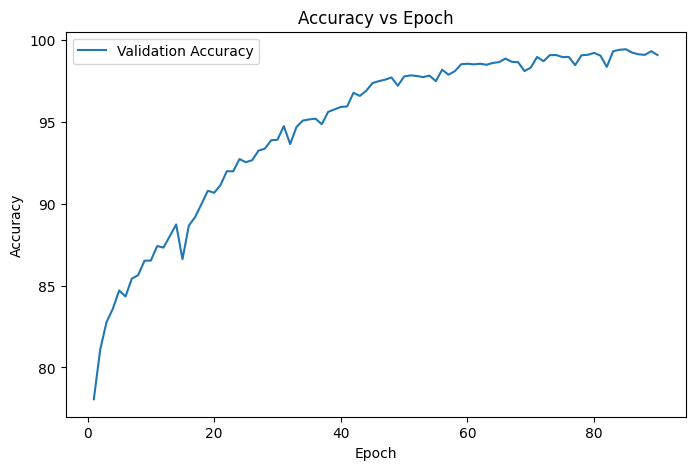

In [ ]:
lossdf = pd.read_csv("resnet50_loss.csv", engine="pyarrow")

l = len(lossdf)
lossdf = lossdf.iloc[l - 90:, :]

# print(lossdf.iloc[0, :])

rolling_mean = lossdf["val_loss"].rolling(window=5).mean()
rolling_mean2 = lossdf["train_loss"].rolling(window=5).mean()

plt.figure(figsize=(8, 5))
plt.plot(lossdf["epoch"], rolling_mean, label="Validation Loss")
# plt.plot(lossdf["epoch"], rolling_mean2, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(lossdf["epoch"], lossdf["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch")
plt.legend()
plt.show()

In [ ]:

# # Import the timm pth models
# model = torch.load("mobilenetv3_large.pth")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create an instance of the VGG16 model
model = timm.create_model('resnet50', pretrained=True, num_classes=2, drop_rate=0.2).to(device)

# Load the saved state dictionary into the model
model.load_state_dict(torch.load('resnet50.pth', map_location=device))

correct = 0
total = 0
all_predicted = []
all_labels = []
counter = 0

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        counter += 1
        if counter % 5000 == 0:
            print(f"Completed {counter} batches")

accuracy = 100 * correct / total

print("Done testing")

Done testing




Accuracy on the test dataset: 99.345563%

Confusion Matrix:
 [[10063    24]
 [  108  9975]]


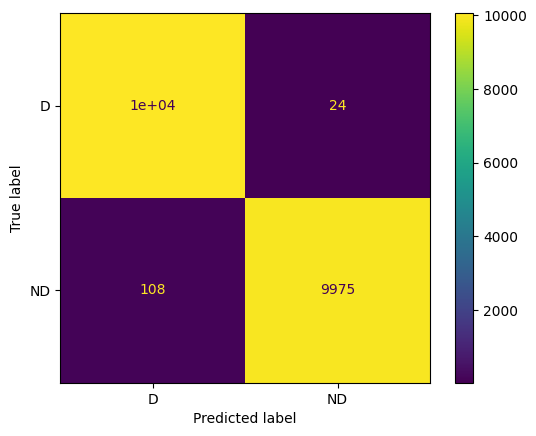


Manual Precision: 0.9975997599759976
Manual Recall: 0.9892889021124666

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     10087
           1       1.00      0.99      0.99     10083

    accuracy                           0.99     20170
   macro avg       0.99      0.99      0.99     20170
weighted avg       0.99      0.99      0.99     20170



AUC-ROC Score: 0.993455


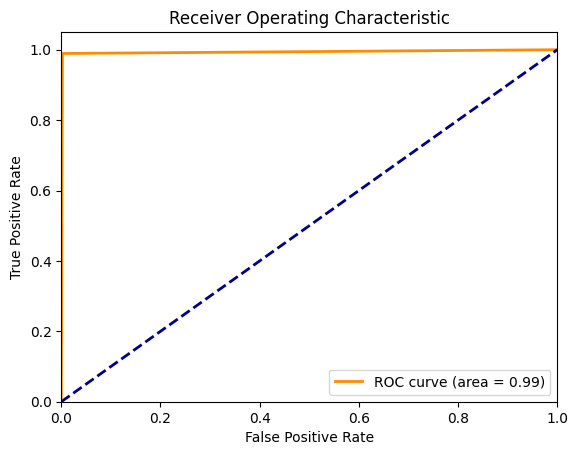

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, classification_report, auc, roc_curve

print('\n\nAccuracy on the test dataset: {:.6f}%'.format(accuracy), end="\n\n")

# Calculate the confusion matrix
confusion = confusion_matrix(all_labels, all_predicted)
print("Confusion Matrix:\n", confusion)
cm = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=["D", "ND"])
cm.plot()
plt.show()
print(cm, end='\n\n')

# Generate precision-recall metrics
precision_manual = precision_score(all_labels, all_predicted)
recall_manual = recall_score(all_labels, all_predicted)

print("Manual Precision:", precision_manual)
print("Manual Recall:", recall_manual, end="\n\n")

# Generate classification report
report = classification_report(all_labels, all_predicted)
print("Classification Report:\n", report, end='\n\n')

# Calculate ROC curve and AUC-ROC score
# fpr, tpr, thresholds = roc_curve(all_labels, outputs.cpu().numpy()[:, 1].astype(float))
fpr, tpr, thresholds = roc_curve(y_true=all_labels, y_score=all_predicted)
roc_auc = auc(fpr, tpr)
print("\nAUC-ROC Score: {:.6f}".format(roc_auc))

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
lossdf = pd.read_csv("vgg16_loss.csv", engine="pyarrow")

rolling_mean = lossdf["val_loss"].rolling(window=5).mean()
rolling_mean2 = lossdf["train_loss"].rolling(window=5).mean()

plt.figure(figsize=(8, 5))
plt.plot(lossdf["epoch"], rolling_mean, label="Validation Loss")
plt.plot(lossdf["epoch"], rolling_mean2, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(lossdf["epoch"], lossdf["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch")
plt.legend()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'vgg16_loss.csv'

Mobilenet

In [ ]:
model = timm.create_model('mobilenetv3_large_100', pretrained=True, num_classes=2, drop_rate=0.2).to(device)

losslogger = CSVLogger('mobilenetv3_large_loss.csv', fieldnames=["datetime", "batch", "epoch", "train_loss", "val_loss", "val_accuracy"])
acclogger = CSVLogger('mobilenetv3_large_acc.csv', fieldnames=["datetime", "average_accuracy"])
loss_value = torch.nn.CrossEntropyLoss()

model_opt = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# Training loop
num_epochs = epochs  
early_stopping = False  
best_loss = float('inf') 

print(f"Device: {device}")

print(f"Start time: {datetime.datetime.now()}")


for epoch in range(num_epochs):
    model.train()  
    # Training
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        model_opt.zero_grad()
        outputs = model(inputs)
        loss = loss_value(outputs, labels)
        loss.backward()
        model_opt.step()
    
    # Validation
    model.eval()  
    total = 0
    correct = 0
    val_loss = 0.0
    for val_inputs, val_labels in val_loader:
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss += loss_value(val_outputs, val_labels).item()
        _, predicted = torch.max(val_outputs.data, 1)
        total += val_labels.size(0)
        correct += (predicted == val_labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    losslog_data = {"datetime": datetime.datetime.now(), "batch": batch_size, "epoch": epoch+1, "train_loss": loss.item(), "val_loss": val_loss, "val_accuracy": val_accuracy}
    losslogger.log(losslog_data)

    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0  
    else:
        patience_counter += 1  
        
        # If validation loss hasn't improved for 'patience' epochs, stop early
        if patience_counter >= patience:
            print("Early stopping triggered")
            early_stopping = True
            break
    
    if early_stopping:
        break
    
    print(f"Completed epoch {epoch + 1} with loss {loss.item()}, validation loss {val_loss}")

# -----------------------------------------

correct = 0
total = 0
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
acclog_data = {"datetime": datetime.datetime.now(), "average_accuracy": accuracy}
acclogger.log(acclog_data)
print('\n\nAccuracy on the test dataset: {:.6f}%'.format(accuracy), end="\n\n")

# Save the model
torch.save(model.state_dict(), 'mobilenetv3_large.pth')


Device: cuda
Start time: 2023-11-02 14:25:26.683058
Completed epoch 1 with loss 0.04055780544877052, validation loss 0.1952510912747868
Completed epoch 2 with loss 0.010466552339494228, validation loss 0.10387345766676566
Completed epoch 3 with loss 0.01143277995288372, validation loss 0.0576947878786769
Completed epoch 4 with loss 0.08788588643074036, validation loss 0.04462453438539581
Completed epoch 5 with loss 0.013846207410097122, validation loss 0.027133099366916196
Completed epoch 6 with loss 0.01576865278184414, validation loss 0.0197745921489662
Completed epoch 7 with loss 0.0002943530271295458, validation loss 0.016098634850136503
Completed epoch 8 with loss 0.0008144935127347708, validation loss 0.014140961983253549
Completed epoch 9 with loss 5.0645190640352666e-05, validation loss 0.011355322558904467
Completed epoch 10 with loss 0.0006969619425944984, validation loss 0.012647938509896435
Completed epoch 11 with loss 6.758944073226303e-05, validation loss 0.00806190688465

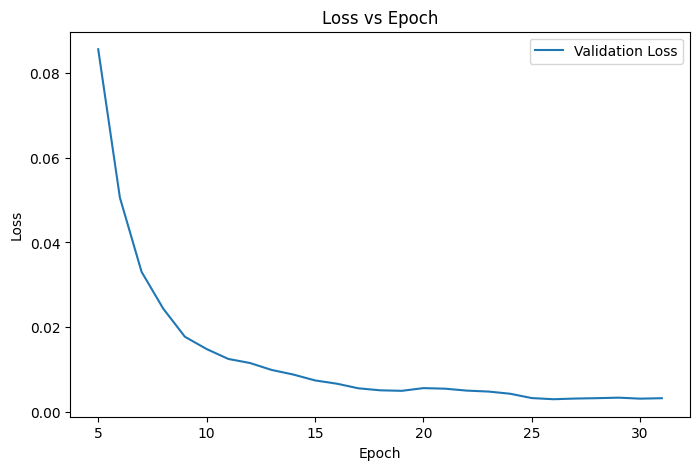

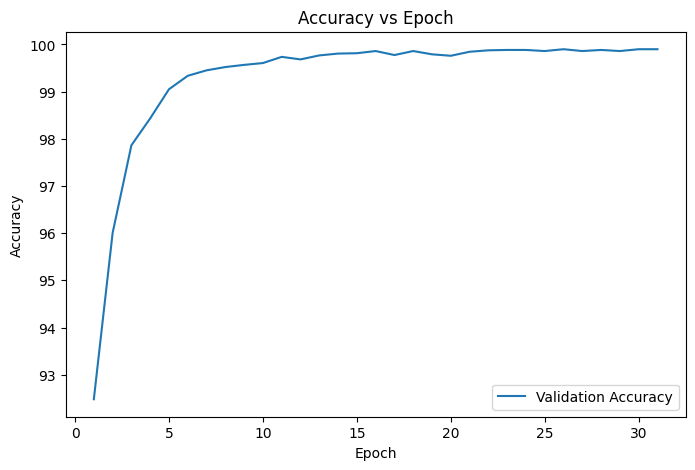

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

lossdf = pd.read_csv("Results/CSVs/mobilenetv3_large_loss.csv", engine="pyarrow")
rolling_mean = lossdf["val_loss"].rolling(window=5).mean()
rolling_mean2 = lossdf["train_loss"].rolling(window=5).mean()

plt.figure(figsize=(8, 5))
plt.plot(lossdf["epoch"], rolling_mean, label="Validation Loss")
# plt.plot(lossdf["epoch"], rolling_mean2, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(lossdf["epoch"], lossdf["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch")
plt.legend()
plt.show()

Densenet

In [ ]:
model = timm.create_model('densenet121', pretrained=True, num_classes=2, drop_rate=0.2).to(device)

losslogger = CSVLogger('densenet121_loss.csv', fieldnames=["datetime", "batch", "epoch", "train_loss", "val_loss", "val_accuracy"])
acclogger = CSVLogger('densenet121_acc.csv', fieldnames=["datetime", "average_accuracy"])
loss_value = torch.nn.CrossEntropyLoss()

model_opt = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# Training loop
num_epochs = epochs  
early_stopping = False  
best_loss = float('inf') 

print(f"Device: {device}")

print(f"Start time: {datetime.datetime.now()}")


for epoch in range(num_epochs):
    model.train()  
    # Training
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        model_opt.zero_grad()
        outputs = model(inputs)
        loss = loss_value(outputs, labels)
        loss.backward()
        model_opt.step()
    
    # Validation
    model.eval()  
    total = 0
    correct = 0
    val_loss = 0.0
    for val_inputs, val_labels in val_loader:
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss += loss_value(val_outputs, val_labels).item()
        _, predicted = torch.max(val_outputs.data, 1)
        total += val_labels.size(0)
        correct += (predicted == val_labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    losslog_data = {"datetime": datetime.datetime.now(), "batch": batch_size, "epoch": epoch+1, "train_loss": loss.item(), "val_loss": val_loss, "val_accuracy": val_accuracy}
    losslogger.log(losslog_data)

    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0  
    else:
        patience_counter += 1  
        
        # If validation loss hasn't improved for 'patience' epochs, stop early
        if patience_counter >= patience:
            print("Early stopping triggered")
            early_stopping = True
            break
    
    if early_stopping:
        break
    
    print(f"Completed epoch {epoch + 1} with loss {loss.item()}, validation loss {val_loss}")

# -----------------------------------------

correct = 0
total = 0
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
acclog_data = {"datetime": datetime.datetime.now(), "average_accuracy": accuracy}
acclogger.log(acclog_data)
print('\n\nAccuracy on the test dataset: {:.6f}%'.format(accuracy), end="\n\n")

# Save the model
torch.save(model.state_dict(), 'densenet121_large.pth')


Device: cuda
Start time: 2023-11-02 21:26:36.331384


KeyboardInterrupt: 

In [ ]:
lossdf = pd.read_csv("densenet121_loss.csv", engine="pyarrow")
rolling_mean = lossdf["val_loss"].rolling(window=5).mean()
rolling_mean2 = lossdf["train_loss"].rolling(window=5).mean()

plt.figure(figsize=(8, 5))
plt.plot(lossdf["epoch"], rolling_mean, label="Validation Loss")
plt.plot(lossdf["epoch"], rolling_mean2, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(lossdf["epoch"], lossdf["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch")
plt.legend()
plt.show()

InceptionV4

In [ ]:
model = timm.create_model('inception_v4', pretrained=True, num_classes=2, drop_rate=0.2).to(device)

losslogger = CSVLogger('inception_v4_loss.csv', fieldnames=["datetime", "batch", "epoch", "train_loss", "val_loss", "val_accuracy"])
acclogger = CSVLogger('inception_v4_acc.csv', fieldnames=["datetime", "average_accuracy"])
loss_value = torch.nn.CrossEntropyLoss()

model_opt = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# Training loop
num_epochs = epochs  
early_stopping = False  
best_loss = float('inf') 

print(f"Device: {device}")

print(f"Start time: {datetime.datetime.now()}")


for epoch in range(num_epochs):
    model.train()  
    # Training
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        model_opt.zero_grad()
        outputs = model(inputs)
        loss = loss_value(outputs, labels)
        loss.backward()
        model_opt.step()
    
    # Validation
    model.eval()  
    total = 0
    correct = 0
    val_loss = 0.0
    for val_inputs, val_labels in val_loader:
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss += loss_value(val_outputs, val_labels).item()
        _, predicted = torch.max(val_outputs.data, 1)
        total += val_labels.size(0)
        correct += (predicted == val_labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    losslog_data = {"datetime": datetime.datetime.now(), "batch": batch_size, "epoch": epoch+1, "train_loss": loss.item(), "val_loss": val_loss, "val_accuracy": val_accuracy}
    losslogger.log(losslog_data)

    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0  
    else:
        patience_counter += 1  
        
        # If validation loss hasn't improved for 'patience' epochs, stop early
        if patience_counter >= patience:
            print("Early stopping triggered")
            early_stopping = True
            break
    
    if early_stopping:
        break
    
    print(f"Completed epoch {epoch + 1} with loss {loss.item()}, validation loss {val_loss}")

# -----------------------------------------

correct = 0
total = 0
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
acclog_data = {"datetime": datetime.datetime.now(), "average_accuracy": accuracy}
acclogger.log(acclog_data)
print('\n\nAccuracy on the test dataset: {:.6f}%'.format(accuracy), end="\n\n")

# Save the model
torch.save(model.state_dict(), 'inception_v4_large.pth')


Device: cuda
Start time: 2023-11-02 21:41:48.314433


KeyboardInterrupt: 

In [ ]:
lossdf = pd.read_csv("inception_v4_loss.csv", engine="pyarrow")
rolling_mean = lossdf["val_loss"].rolling(window=5).mean()
rolling_mean2 = lossdf["train_loss"].rolling(window=5).mean()

plt.figure(figsize=(8, 5))
plt.plot(lossdf["epoch"], rolling_mean, label="Validation Loss")
plt.plot(lossdf["epoch"], rolling_mean2, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(lossdf["epoch"], lossdf["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch")
plt.legend()
plt.show()

Vgg16

In [ ]:
model = timm.create_model('vgg16', pretrained=True, num_classes=2, drop_rate=0.2).to(device)

losslogger = CSVLogger('vgg16_loss.csv', fieldnames=["datetime", "batch", "epoch", "train_loss", "val_loss", "val_accuracy"])
acclogger = CSVLogger('vgg16_acc.csv', fieldnames=["datetime", "average_accuracy"])
loss_value = torch.nn.CrossEntropyLoss()

model_opt = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# Training loop
num_epochs = epochs  
early_stopping = False  
best_loss = float('inf') 

print(f"Device: {device}")

print(f"Start time: {datetime.datetime.now()}")


for epoch in range(num_epochs):
    model.train()  
    # Training
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        model_opt.zero_grad()
        outputs = model(inputs)
        loss = loss_value(outputs, labels)
        loss.backward()
        model_opt.step()

    print("Training done")
    
    # Validation
    model.eval()  
    total = 0
    correct = 0
    val_loss = 0.0
    for val_inputs, val_labels in val_loader:
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss += loss_value(val_outputs, val_labels).item()
        _, predicted = torch.max(val_outputs.data, 1)
        total += val_labels.size(0)
        correct += (predicted == val_labels).sum().item()

    print("Validation done")
    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    losslog_data = {"datetime": datetime.datetime.now(), "batch": batch_size, "epoch": epoch+1, "train_loss": loss.item(), "val_loss": val_loss, "val_accuracy": val_accuracy}
    losslogger.log(losslog_data)

    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0  
    else:
        patience_counter += 1  
        
        # If validation loss hasn't improved for 'patience' epochs, stop early
        if patience_counter >= patience:
            print("Early stopping triggered")
            early_stopping = True
            break
    
    if early_stopping:
        break
    
    print(f"Completed epoch {epoch + 1} with loss {loss.item()}, validation loss {val_loss}")

# -----------------------------------------

correct = 0
total = 0
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
acclog_data = {"datetime": datetime.datetime.now(), "average_accuracy": accuracy}
acclogger.log(acclog_data)
print('\n\nAccuracy on the test dataset: {:.6f}%'.format(accuracy), end="\n\n")

# Save the model
torch.save(model.state_dict(), 'vgg16_large.pth')

# -----------------------------------------

Device: cuda
Start time: 2023-11-02 14:14:49.279462


KeyboardInterrupt: 

Inceptionv3


#### Testing the models and getting confusion matrix, precision recall, and auc-roc 

In [ ]:
print(device)

cuda


In [ ]:
import torch
import timm
import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, auc, roc_curve, roc_auc_score, precision_score, recall_score, ConfusionMatrixDisplay


In [ ]:

# # Import the timm pth models
# model = torch.load("mobilenetv3_large.pth")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create an instance of the VGG16 model
model = timm.create_model('mobilenetv3_large_100', num_classes=2, drop_rate=0.2).to(device)

# Load the saved state dictionary into the model
model.load_state_dict(torch.load('mobilenetv3_large.pth', map_location=device))

correct = 0
total = 0
all_predicted = []
all_labels = []
counter = 0

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        counter += 1
        if counter % 5000 == 0:
            print(f"Completed {counter} batches")

accuracy = 100 * correct / total

print("Done testing")

Done testing


In [ ]:
# y_true = all_labels  # Ensure y_true is a one-dimensional array
# y_score = outputs.cpu().numpy()[:, 1].astype(float)  # Ensure y_score is a one-dimensional array with the same length

# print(y_true.shape)
# print(y_score.shape)



Accuracy on the test dataset: 99.960337%

Confusion Matrix:
 [[10082     5]
 [    3 10080]]


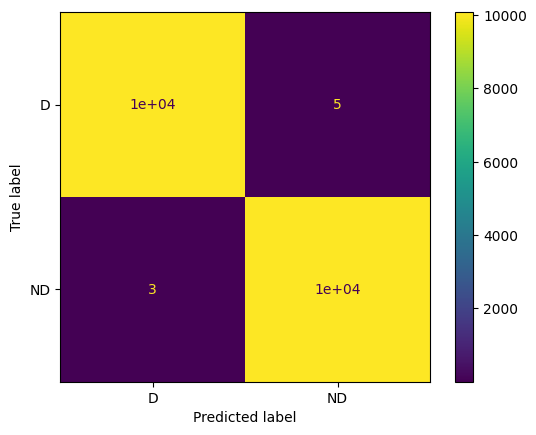


Manual Precision: 0.9995042141794744
Manual Recall: 0.999702469503124

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     10087
           1       1.00      1.00      1.00     10083

    accuracy                           1.00     20170
   macro avg       1.00      1.00      1.00     20170
weighted avg       1.00      1.00      1.00     20170



AUC-ROC Score: 0.999603


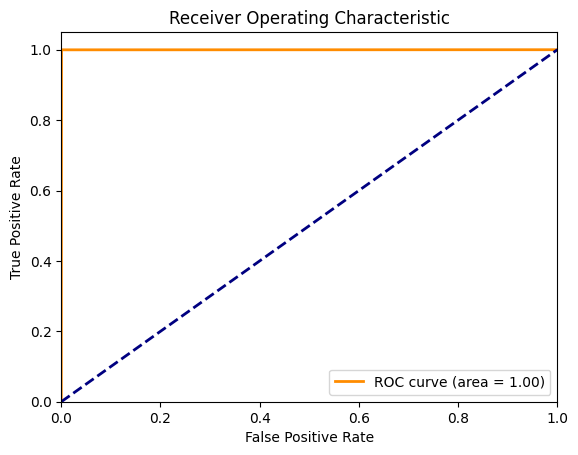

In [ ]:
print('\n\nAccuracy on the test dataset: {:.6f}%'.format(accuracy), end="\n\n")

# Calculate the confusion matrix
confusion = confusion_matrix(all_labels, all_predicted)
print("Confusion Matrix:\n", confusion)
cm = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=["D", "ND"])
cm.plot()
plt.show()
print(cm, end='\n\n')

# Generate precision-recall metrics
precision_manual = precision_score(all_labels, all_predicted)
recall_manual = recall_score(all_labels, all_predicted)

print("Manual Precision:", precision_manual)
print("Manual Recall:", recall_manual, end="\n\n")

# Generate classification report
report = classification_report(all_labels, all_predicted)
print("Classification Report:\n", report, end='\n\n')

# Calculate ROC curve and AUC-ROC score
# fpr, tpr, thresholds = roc_curve(all_labels, outputs.cpu().numpy()[:, 1].astype(float))
fpr, tpr, thresholds = roc_curve(y_true=all_labels, y_score=all_predicted)
roc_auc = auc(fpr, tpr)
print("\nAUC-ROC Score: {:.6f}".format(roc_auc))

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

#### Yet another test

In [ ]:
# Define transformations for image preprocessing
transform2 = transforms.Compose([
    transforms.Resize((176, 208)),  # Resize images to a common size (adjust as needed)
    transforms.ToTensor(),           # Convert images to tensors
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),  # Normalize using ImageNet stats
])

# Load training and testing datasets
# train_dataset = ImageFolder(root='Binary_ttv\\train', transform=transform2)
test_dataset = ImageFolder(root='NewBinary_TTV\\test', transform=transform2)
# val_dataset = ImageFolder(root='Binary_ttv\\val', transform=transform2)

batch_size = 26  # Adjust as needed
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
# val_loader = DataLoader(val_dataset, batch_size=batch_size)

# print(len(train_loader))
print(len(test_loader))
# print(len(val_loader))
# print(len(train_dataset))
print(len(test_dataset))
# print(len(val_dataset))

776
20166


In [ ]:
import torch
import timm
import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, auc, roc_curve, precision_score, recall_score, ConfusionMatrixDisplay

Mobilenet

In [ ]:

# # Import the timm pth models
# model = torch.load("mobilenetv3_large.pth")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
# Create an instance of the model
model = timm.create_model('mobilenetv3_large_100', num_classes=2, drop_rate=0.2).to(device)

# Load the saved state dictionary into the model
model.load_state_dict(torch.load('Models/Model_mobilenetv3_large.pth', map_location=device))

correct = 0
total = 0
all_predicted = []
all_labels = []
counter = 0

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        counter += 1
        if counter % 5000 == 0:
            print(f"Completed {counter} batches")

accuracy = 100 * correct / total

print("Done testing")



Device: cuda
Done testing




Accuracy on the test dataset: 99.980165%

Confusion Matrix:
 [[10080     3]
 [    1 10082]]


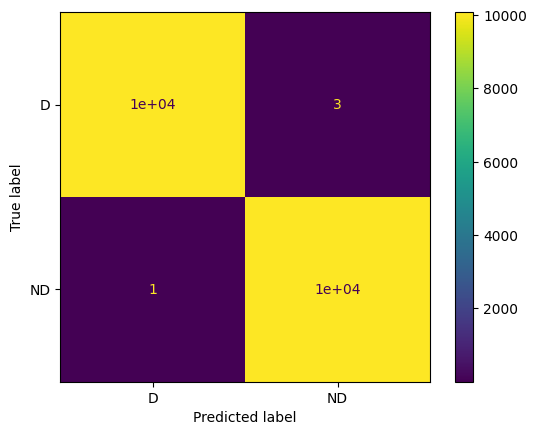


Manual Precision: 0.9997025285076847
Manual Recall: 0.999900823167708

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     10083
           1       1.00      1.00      1.00     10083

    accuracy                           1.00     20166
   macro avg       1.00      1.00      1.00     20166
weighted avg       1.00      1.00      1.00     20166



AUC-ROC Score: 0.999802


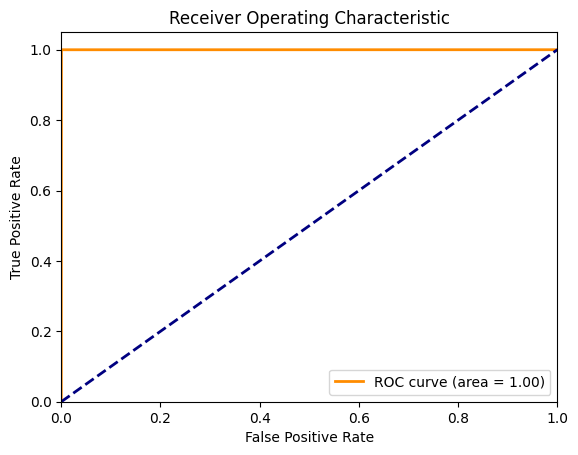

In [ ]:
print('\n\nAccuracy on the test dataset: {:.6f}%'.format(accuracy), end="\n\n")

# Calculate the confusion matrix
confusion = confusion_matrix(all_labels, all_predicted)
print("Confusion Matrix:\n", confusion)
cm = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=["D", "ND"])
cm.plot()
plt.show()
print(cm, end='\n\n')

# Generate precision-recall metrics
precision_manual = precision_score(all_labels, all_predicted)
recall_manual = recall_score(all_labels, all_predicted)

print("Manual Precision:", precision_manual)
print("Manual Recall:", recall_manual, end="\n\n")

# Generate classification report
report = classification_report(all_labels, all_predicted)
print("Classification Report:\n", report, end='\n\n')

# Calculate ROC curve and AUC-ROC score
# fpr, tpr, thresholds = roc_curve(all_labels, outputs.cpu().numpy()[:, 1].astype(float))
fpr, tpr, thresholds = roc_curve(y_true=all_labels, y_score=all_predicted)
roc_auc = auc(fpr, tpr)
print("\nAUC-ROC Score: {:.6f}".format(roc_auc))

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Resnet50

In [ ]:

# # Import the timm pth models
# model = torch.load("mobilenetv3_large.pth")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
# Create an instance of the model
model = timm.create_model('resnet50', num_classes=2, drop_rate=0.2).to(device)

# Load the saved state dictionary into the model
model.load_state_dict(torch.load('Models/Model_resnet50.pth', map_location=device))

correct = 0
total = 0
all_predicted = []
all_labels = []
counter = 0

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        counter += 1
        if counter % 5000 == 0:
            print(f"Completed {counter} batches")

accuracy = 100 * correct / total

print("Done testing")



Device: cuda
Done testing




Accuracy on the test dataset: 99.742140%

Confusion Matrix:
 [[10080     3]
 [   49 10034]]


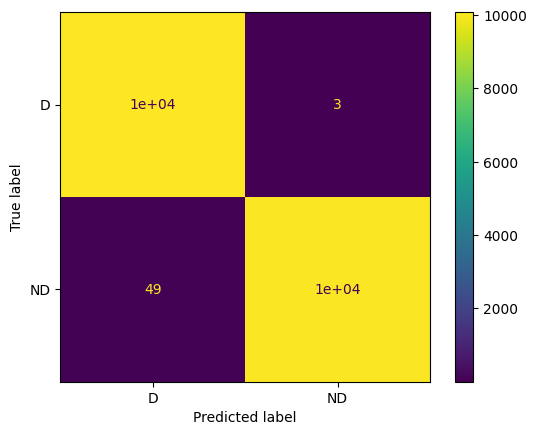


Manual Precision: 0.9997011059081399
Manual Recall: 0.9951403352176932

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     10083
           1       1.00      1.00      1.00     10083

    accuracy                           1.00     20166
   macro avg       1.00      1.00      1.00     20166
weighted avg       1.00      1.00      1.00     20166



AUC-ROC Score: 0.997421


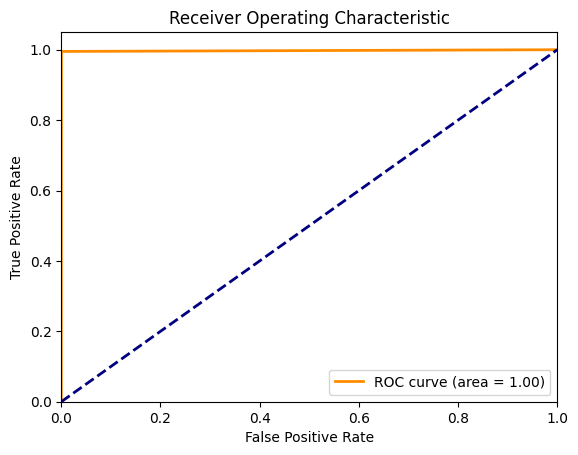

In [ ]:
print('\n\nAccuracy on the test dataset: {:.6f}%'.format(accuracy), end="\n\n")

# Calculate the confusion matrix
confusion = confusion_matrix(all_labels, all_predicted)
print("Confusion Matrix:\n", confusion)
cm = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=["D", "ND"])
cm.plot()
plt.show()
print(cm, end='\n\n')

# Generate precision-recall metrics
precision_manual = precision_score(all_labels, all_predicted)
recall_manual = recall_score(all_labels, all_predicted)

print("Manual Precision:", precision_manual)
print("Manual Recall:", recall_manual, end="\n\n")

# Generate classification report
report = classification_report(all_labels, all_predicted)
print("Classification Report:\n", report, end='\n\n')

# Calculate ROC curve and AUC-ROC score
# fpr, tpr, thresholds = roc_curve(all_labels, outputs.cpu().numpy()[:, 1].astype(float))
fpr, tpr, thresholds = roc_curve(y_true=all_labels, y_score=all_predicted)
roc_auc = auc(fpr, tpr)
print("\nAUC-ROC Score: {:.6f}".format(roc_auc))

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

---------------------------------------------------------
### Working with Binary_TTV_over_under_train - Resnet50

In [2]:
import torch
import timm
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch
import torch.optim as optim
import os
import random
import shutil
from torchvision import datasets
from csvlogger import CSVLogger
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from tqdm import tqdm


In [3]:
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
 
# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device: {torch.cuda.current_device()}")
       
print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Device: {device}")

Is CUDA supported by this system? True
CUDA version: 11.8
ID of current CUDA device: 0
Name of current CUDA device: NVIDIA GeForce RTX 3060 Laptop GPU
Device: cuda


In [4]:
print(os.listdir('Binary_TTV_over_under_train\\train'))
print(os.listdir('Binary_TTV_over_under_train\\test'))
print(os.listdir('Binary_TTV_over_under_train\\val'))

['Demented', 'NonDemented']
['Demented', 'NonDemented']
['Demented', 'NonDemented']


Creating Loaders

In [6]:
# Define transformations for image preprocessing
transform = transforms.Compose([
    transforms.Resize((176, 208)),  # Resize images to a common size (adjust as needed)
    transforms.ToTensor(),           # Convert images to tensors
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),  # Normalize using ImageNet stats
])

# Load training and testing datasets
test_dataset2 = ImageFolder(root='Binary_TTV_over_under_all\\test', transform=transform)

batch_size = 26  # Adjust as needed
num_workers = 4  # Number of subprocesses to use for data loading
pin_memory = True  # Whether to use pinned memory for faster data transfer to GPU

test_loader2 = DataLoader(test_dataset2, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory)

print(len(test_loader2))
print(len(test_dataset2))

499
12964


In [4]:
# Define transformations for image preprocessing
transform = transforms.Compose([
    transforms.Resize((176, 208)),  # Resize images to a common size (adjust as needed)
    transforms.ToTensor(),           # Convert images to tensors
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),  # Normalize using ImageNet stats
])

# Load training and testing datasets
train_dataset = ImageFolder(root='Binary_TTV_over_under_train\\train', transform=transform)
test_dataset = ImageFolder(root='Binary_TTV_over_under_train\\test', transform=transform)
val_dataset = ImageFolder(root='Binary_TTV_over_under_train\\val', transform=transform)

batch_size = 26  # Adjust as needed
num_workers = 4  # Number of subprocesses to use for data loading
pin_memory = True  # Whether to use pinned memory for faster data transfer to GPU

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory)

print(len(train_loader))
print(len(test_loader))
print(len(val_loader))
print(len(train_dataset))
print(len(test_dataset))
print(len(val_dataset))

2328
499
499
60510
12965
12967


In [5]:
learning_rate = 0.0001
epochs = 100
patience = 5

In [12]:
model = timm.create_model('resnet50', pretrained=True, num_classes=2, drop_rate=0.2).to(device)

losslogger = CSVLogger('new_resnet50_loss.csv', fieldnames=["datetime", "batch", "epoch", "train_loss", "val_loss", "val_accuracy"])
acclogger = CSVLogger('new_resnet50_acc.csv', fieldnames=["datetime", "average_accuracy"])
loss_value = torch.nn.CrossEntropyLoss()

model_opt = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# Training loop
num_epochs = epochs  
early_stopping = False  
best_loss = float('inf') 
counter = 0

print(f"Device: {device}")

print(f"Start time: {datetime.datetime.now()}")
print(f"Number of epochs: {num_epochs}")

for epoch in range(num_epochs):
    model.train()  
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    # Training
    for batch_idx, (inputs, labels) in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        model_opt.zero_grad()
        outputs = model(inputs)
        loss = loss_value(outputs, labels)
        loss.backward()
        model_opt.step()
        counter += 1

        # Update tqdm progress bar
        pbar.set_postfix({'Loss': f'{loss.item():.4f}'})
    
    pbar.close()
    
    # Validation
    model.eval()  
    total = 0
    correct = 0
    val_loss = 0.0
    for val_inputs, val_labels in val_loader:
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss += loss_value(val_outputs, val_labels).item()
        _, predicted = torch.max(val_outputs.data, 1)
        total += val_labels.size(0)
        correct += (predicted == val_labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    losslog_data = {"datetime": datetime.datetime.now(), "batch": batch_size, "epoch": epoch+1, "train_loss": loss.item(), "val_loss": val_loss, "val_accuracy": val_accuracy}
    losslogger.log(losslog_data)

    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0  
    else:
        patience_counter += 1  
        
        # If validation loss hasn't improved for 'patience' epochs, stop early
        if patience_counter >= patience:
            print("Early stopping triggered")
            early_stopping = True
            break
    
    if early_stopping:
        break
    
    print(f"Completed epoch {epoch + 1} with loss {loss.item()}, validation loss {val_loss}")

# -----------------------------------------

correct = 0
total = 0
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
acclog_data = {"datetime": datetime.datetime.now(), "average_accuracy": accuracy}
acclogger.log(acclog_data)
print('\n\nAccuracy on the test dataset: {:.6f}%'.format(accuracy), end="\n\n")

# -----------------------------------------


torch.save(model.state_dict(), 'Models/new_resnet50.pth')

Device: cuda
Start time: 2023-11-11 16:12:44.314248
Number of epochs: 100


100%|██████████| 2328/2328 [04:38<00:00,  8.37it/s, Loss=0.5086]


Completed epoch 1 with loss 0.5085656046867371, validation loss 0.4641910138314138


100%|██████████| 2328/2328 [04:38<00:00,  8.35it/s, Loss=0.1971]


Completed epoch 2 with loss 0.19710637629032135, validation loss 0.48014106482028485


100%|██████████| 2328/2328 [04:40<00:00,  8.29it/s, Loss=1.2605]


Completed epoch 3 with loss 1.2605270147323608, validation loss 0.380594666927814


100%|██████████| 2328/2328 [04:44<00:00,  8.17it/s, Loss=0.2397]


Completed epoch 4 with loss 0.23966151475906372, validation loss 0.40107884732838384


100%|██████████| 2328/2328 [04:40<00:00,  8.31it/s, Loss=0.2705]


Completed epoch 5 with loss 0.27048459649086, validation loss 0.36505699077460596


100%|██████████| 2328/2328 [04:41<00:00,  8.27it/s, Loss=0.1402]


Completed epoch 6 with loss 0.1402086615562439, validation loss 0.3401738726972548


100%|██████████| 2328/2328 [04:40<00:00,  8.31it/s, Loss=0.2512]


Completed epoch 7 with loss 0.25116032361984253, validation loss 0.3266658796844836


100%|██████████| 2328/2328 [04:40<00:00,  8.30it/s, Loss=0.2432]


Completed epoch 8 with loss 0.24320019781589508, validation loss 0.35677826624617487


100%|██████████| 2328/2328 [04:40<00:00,  8.30it/s, Loss=0.0951]


Completed epoch 9 with loss 0.0950923040509224, validation loss 0.31133070583912525


100%|██████████| 2328/2328 [04:41<00:00,  8.28it/s, Loss=0.3077]


Completed epoch 10 with loss 0.3077203035354614, validation loss 0.3162911881754298


100%|██████████| 2328/2328 [04:44<00:00,  8.17it/s, Loss=0.3680]


Completed epoch 11 with loss 0.3679632544517517, validation loss 0.29707174906077866


100%|██████████| 2328/2328 [04:42<00:00,  8.25it/s, Loss=0.6974]


Completed epoch 12 with loss 0.6973761916160583, validation loss 0.3360158036106484


100%|██████████| 2328/2328 [04:38<00:00,  8.35it/s, Loss=0.4319]


Completed epoch 13 with loss 0.43188363313674927, validation loss 0.2750246556501888


100%|██████████| 2328/2328 [04:40<00:00,  8.30it/s, Loss=0.4828]


Completed epoch 14 with loss 0.48277801275253296, validation loss 0.29877701151242597


100%|██████████| 2328/2328 [04:39<00:00,  8.33it/s, Loss=0.4022]


Completed epoch 15 with loss 0.40219971537590027, validation loss 0.3166910914483971


100%|██████████| 2328/2328 [04:39<00:00,  8.33it/s, Loss=0.2883]


Completed epoch 16 with loss 0.28834497928619385, validation loss 0.2611765326849952


100%|██████████| 2328/2328 [04:39<00:00,  8.33it/s, Loss=0.5329]


Completed epoch 17 with loss 0.5328921675682068, validation loss 0.2505691840732377


100%|██████████| 2328/2328 [04:39<00:00,  8.32it/s, Loss=0.0955]


Completed epoch 18 with loss 0.09550166130065918, validation loss 0.2547074649772254


100%|██████████| 2328/2328 [04:39<00:00,  8.34it/s, Loss=0.2145]


Completed epoch 19 with loss 0.21447165310382843, validation loss 0.24785074602881585


100%|██████████| 2328/2328 [04:38<00:00,  8.35it/s, Loss=0.1498]


Completed epoch 20 with loss 0.14982271194458008, validation loss 0.2521731612447067


100%|██████████| 2328/2328 [04:39<00:00,  8.33it/s, Loss=0.2125]


Completed epoch 21 with loss 0.21253763139247894, validation loss 0.22779073189609947


100%|██████████| 2328/2328 [04:38<00:00,  8.35it/s, Loss=0.1782]


Completed epoch 22 with loss 0.17818555235862732, validation loss 0.2170643379420923


100%|██████████| 2328/2328 [04:38<00:00,  8.34it/s, Loss=0.1247]


Completed epoch 23 with loss 0.12472905963659286, validation loss 0.3885594761588859


100%|██████████| 2328/2328 [04:42<00:00,  8.25it/s, Loss=0.0620]


Completed epoch 24 with loss 0.06195548176765442, validation loss 0.20100063526091205


100%|██████████| 2328/2328 [04:39<00:00,  8.34it/s, Loss=0.3048]


Completed epoch 25 with loss 0.30481916666030884, validation loss 0.20406718331180096


100%|██████████| 2328/2328 [04:39<00:00,  8.34it/s, Loss=0.1185]


Completed epoch 26 with loss 0.11847887933254242, validation loss 0.21284840714544775


100%|██████████| 2328/2328 [04:39<00:00,  8.32it/s, Loss=0.2769]


Completed epoch 27 with loss 0.2769431471824646, validation loss 0.2300249001063511


100%|██████████| 2328/2328 [04:39<00:00,  8.33it/s, Loss=0.1691]


Completed epoch 28 with loss 0.1690833568572998, validation loss 0.19160788422469088


100%|██████████| 2328/2328 [04:39<00:00,  8.32it/s, Loss=0.2774]


Completed epoch 29 with loss 0.27740755677223206, validation loss 0.17059324437718304


100%|██████████| 2328/2328 [04:39<00:00,  8.33it/s, Loss=0.2485]


Completed epoch 30 with loss 0.2485286146402359, validation loss 0.1970605422749197


100%|██████████| 2328/2328 [04:39<00:00,  8.32it/s, Loss=0.0297]


Completed epoch 31 with loss 0.029688643291592598, validation loss 0.2378176817176341


100%|██████████| 2328/2328 [04:39<00:00,  8.33it/s, Loss=0.0160]


Completed epoch 32 with loss 0.015962708741426468, validation loss 0.1513295981495031


100%|██████████| 2328/2328 [04:39<00:00,  8.34it/s, Loss=0.1916]


Completed epoch 33 with loss 0.19162198901176453, validation loss 0.1664089470302018


100%|██████████| 2328/2328 [04:41<00:00,  8.27it/s, Loss=0.2150]


Completed epoch 34 with loss 0.21501241624355316, validation loss 0.19335488577031312


100%|██████████| 2328/2328 [06:32<00:00,  5.93it/s, Loss=0.2270]


Completed epoch 35 with loss 0.22696729004383087, validation loss 0.139249645011933


100%|██████████| 2328/2328 [06:34<00:00,  5.91it/s, Loss=0.0304]


Completed epoch 36 with loss 0.030388398095965385, validation loss 0.1385620631508992


100%|██████████| 2328/2328 [06:33<00:00,  5.91it/s, Loss=0.0836]


Completed epoch 37 with loss 0.08358240127563477, validation loss 0.13834175840755067


100%|██████████| 2328/2328 [06:34<00:00,  5.91it/s, Loss=0.3235]


Completed epoch 38 with loss 0.32353782653808594, validation loss 0.14614866393254808


100%|██████████| 2328/2328 [05:14<00:00,  7.41it/s, Loss=0.0765]


Completed epoch 39 with loss 0.07654733210802078, validation loss 0.1323622736835713


100%|██████████| 2328/2328 [04:36<00:00,  8.43it/s, Loss=0.1081]


Completed epoch 40 with loss 0.10807902365922928, validation loss 0.15146380307515994


100%|██████████| 2328/2328 [04:35<00:00,  8.44it/s, Loss=0.1938]


Completed epoch 41 with loss 0.193793386220932, validation loss 0.18122116037091998


100%|██████████| 2328/2328 [04:35<00:00,  8.44it/s, Loss=0.1508]


Completed epoch 42 with loss 0.15080490708351135, validation loss 0.13123348905542306


100%|██████████| 2328/2328 [04:35<00:00,  8.44it/s, Loss=0.0249]


Completed epoch 43 with loss 0.02491166442632675, validation loss 0.14465865393482777


100%|██████████| 2328/2328 [04:37<00:00,  8.39it/s, Loss=0.1544]


Completed epoch 44 with loss 0.15438608825206757, validation loss 0.12748264863700765


100%|██████████| 2328/2328 [04:37<00:00,  8.38it/s, Loss=0.0904]


Completed epoch 45 with loss 0.09043906629085541, validation loss 0.13994990716926764


100%|██████████| 2328/2328 [04:36<00:00,  8.43it/s, Loss=0.0975]


Completed epoch 46 with loss 0.09753120690584183, validation loss 0.11338084019234246


100%|██████████| 2328/2328 [04:35<00:00,  8.44it/s, Loss=0.6024]


Completed epoch 47 with loss 0.6024289131164551, validation loss 0.11201713179233008


100%|██████████| 2328/2328 [04:37<00:00,  8.40it/s, Loss=0.0194]


Completed epoch 48 with loss 0.019399868324398994, validation loss 0.08529545514167096


100%|██████████| 2328/2328 [04:36<00:00,  8.43it/s, Loss=0.0014]


Completed epoch 49 with loss 0.0013773890677839518, validation loss 0.09005715123278939


100%|██████████| 2328/2328 [04:36<00:00,  8.42it/s, Loss=0.0463]


Completed epoch 50 with loss 0.0462765209376812, validation loss 0.14397049461139594


100%|██████████| 2328/2328 [04:35<00:00,  8.45it/s, Loss=0.3996]


Completed epoch 51 with loss 0.39961010217666626, validation loss 0.07966129047697737


100%|██████████| 2328/2328 [04:35<00:00,  8.45it/s, Loss=0.2712]


Completed epoch 52 with loss 0.2711777687072754, validation loss 0.10083236012916698


100%|██████████| 2328/2328 [04:35<00:00,  8.44it/s, Loss=0.0104]


Completed epoch 53 with loss 0.010373291559517384, validation loss 0.11198035156367897


100%|██████████| 2328/2328 [04:35<00:00,  8.44it/s, Loss=0.3751]


Completed epoch 54 with loss 0.37510862946510315, validation loss 0.10648008809638229


100%|██████████| 2328/2328 [04:35<00:00,  8.44it/s, Loss=0.0720]


Completed epoch 55 with loss 0.07195134460926056, validation loss 0.10049966454630384


100%|██████████| 2328/2328 [04:41<00:00,  8.28it/s, Loss=0.5030]


Early stopping triggered


Accuracy on the test dataset: 96.945623%



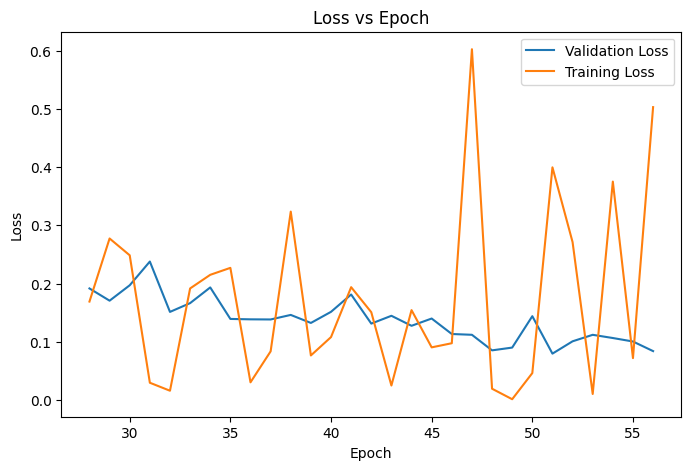

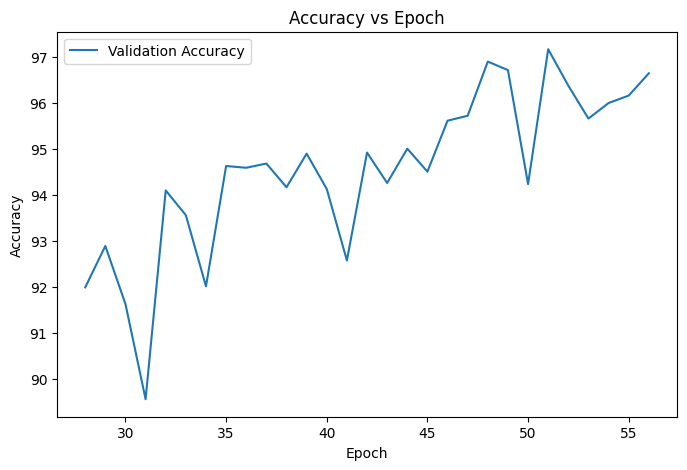

In [17]:
lossdf = pd.read_csv("new_resnet50_loss.csv", engine="pyarrow")

l = len(lossdf)
lossdf = lossdf.iloc[l - 90:, :]

# print(lossdf.iloc[0, :])

rolling_mean = lossdf["val_loss"].rolling(window=5).mean()
rolling_mean2 = lossdf["train_loss"].rolling(window=5).mean()

plt.figure(figsize=(8, 5))
plt.plot(lossdf["epoch"], lossdf["val_loss"], label="Validation Loss")
plt.plot(lossdf["epoch"], lossdf["train_loss"], label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(lossdf["epoch"], lossdf["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch")
plt.legend()
plt.show()

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create an instance of the VGG16 model
model = timm.create_model('resnet50', pretrained=True, num_classes=2, drop_rate=0.2).to(device)

# Load the saved state dictionary into the model
model.load_state_dict(torch.load('Models/new_resnet50.pth', map_location=device))

correct = 0
total = 0
all_predicted = []
all_labels = []
counter = 0

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        counter += 1
        if counter % 5000 == 0:
            print(f"Completed {counter} batches")

accuracy = 100 * correct / total

print("Done testing")

Done testing




Accuracy on the test dataset: 96.945623%

Confusion Matrix:
 [[2808   74]
 [ 322 9761]]


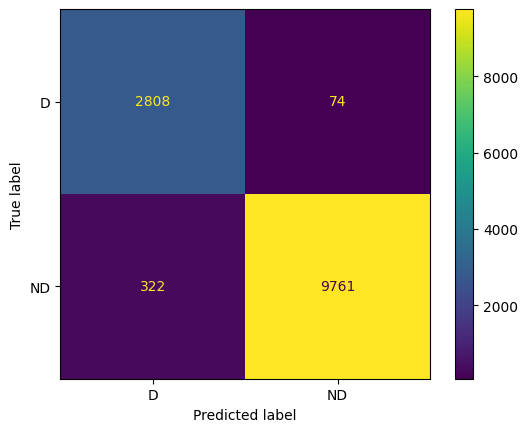


Manual Precision: 0.9924758515505846
Manual Recall: 0.9680650600019836

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.97      0.93      2882
           1       0.99      0.97      0.98     10083

    accuracy                           0.97     12965
   macro avg       0.94      0.97      0.96     12965
weighted avg       0.97      0.97      0.97     12965



AUC-ROC Score: 0.971194


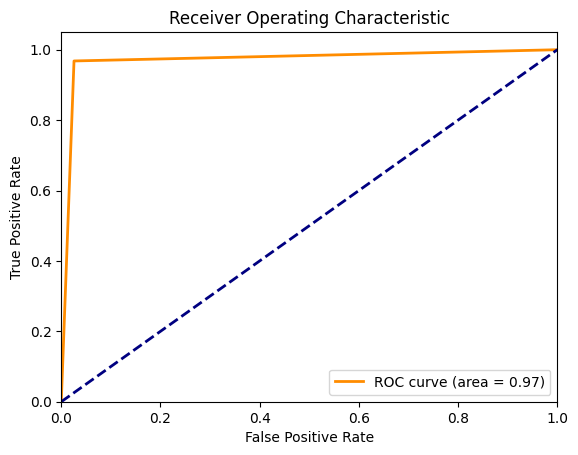

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, classification_report, auc, roc_curve

print('\n\nAccuracy on the test dataset: {:.6f}%'.format(accuracy), end="\n\n")

# Calculate the confusion matrix
confusion = confusion_matrix(all_labels, all_predicted)
print("Confusion Matrix:\n", confusion)
cm = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=["D", "ND"])
cm.plot()
plt.show()
print(cm, end='\n\n')

# Generate precision-recall metrics
precision_manual = precision_score(all_labels, all_predicted)
recall_manual = recall_score(all_labels, all_predicted)

print("Manual Precision:", precision_manual)
print("Manual Recall:", recall_manual, end="\n\n")

# Generate classification report
report = classification_report(all_labels, all_predicted)
print("Classification Report:\n", report, end='\n\n')

# Calculate ROC curve and AUC-ROC score
# fpr, tpr, thresholds = roc_curve(all_labels, outputs.cpu().numpy()[:, 1].astype(float))
fpr, tpr, thresholds = roc_curve(y_true=all_labels, y_score=all_predicted)
roc_auc = auc(fpr, tpr)
print("\nAUC-ROC Score: {:.6f}".format(roc_auc))

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Testing on augmented test dataset

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create an instance of the VGG16 model
model = timm.create_model('resnet50', pretrained=True, num_classes=2, drop_rate=0.2).to(device)

# Load the saved state dictionary into the model
model.load_state_dict(torch.load('Models/new_resnet50.pth', map_location=device))

correct = 0
total = 0
all_predicted = []
all_labels = []
counter = 0

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for inputs, labels in test_loader2:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        counter += 1

accuracy = 100 * correct / total

print("Done testing")

Done testing




Accuracy on the test dataset: 98.565258%

Confusion Matrix:
 [[6440   42]
 [ 144 6338]]


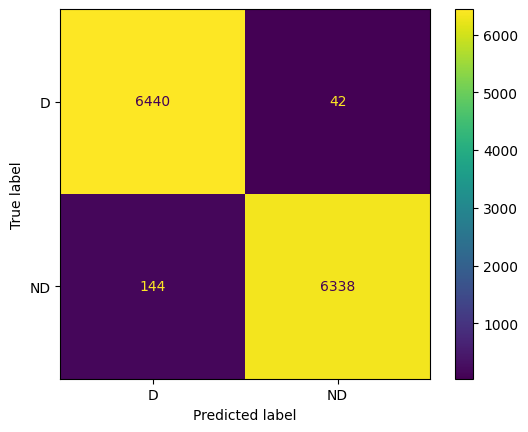


Manual Precision: 0.9934169278996865
Manual Recall: 0.9777846343721074

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      6482
           1       0.99      0.98      0.99      6482

    accuracy                           0.99     12964
   macro avg       0.99      0.99      0.99     12964
weighted avg       0.99      0.99      0.99     12964



AUC-ROC Score: 0.985653


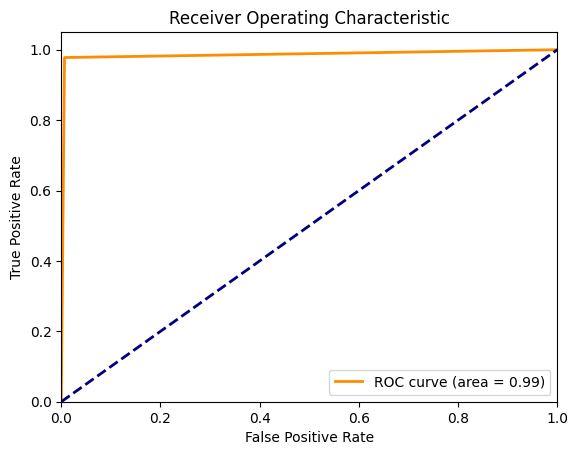

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, classification_report, auc, roc_curve

print('\n\nAccuracy on the test dataset: {:.6f}%'.format(accuracy), end="\n\n")

# Calculate the confusion matrix
confusion = confusion_matrix(all_labels, all_predicted)
print("Confusion Matrix:\n", confusion)
cm = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=["D", "ND"])
cm.plot()
plt.show()
print(cm, end='\n\n')

# Generate precision-recall metrics
precision_manual = precision_score(all_labels, all_predicted)
recall_manual = recall_score(all_labels, all_predicted)

print("Manual Precision:", precision_manual)
print("Manual Recall:", recall_manual, end="\n\n")

# Generate classification report
report = classification_report(all_labels, all_predicted)
print("Classification Report:\n", report, end='\n\n')

# Calculate ROC curve and AUC-ROC score
# fpr, tpr, thresholds = roc_curve(all_labels, outputs.cpu().numpy()[:, 1].astype(float))
fpr, tpr, thresholds = roc_curve(y_true=all_labels, y_score=all_predicted)
roc_auc = auc(fpr, tpr)
print("\nAUC-ROC Score: {:.6f}".format(roc_auc))

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

---------------------------------------------------------
### Working with Binary_TTV_over_under_train - Mobilenet

In [6]:
model = timm.create_model('mobilenetv3_large_100', pretrained=True, num_classes=2, drop_rate=0.2).to(device)

losslogger = CSVLogger('new_mobilenetv3_large_loss.csv', fieldnames=["datetime", "batch", "epoch", "train_loss", "val_loss", "val_accuracy"])
acclogger = CSVLogger('new_mobilenetv3_large_acc.csv', fieldnames=["datetime", "average_accuracy"])
loss_value = torch.nn.CrossEntropyLoss()

model_opt = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# Training loop
num_epochs = epochs  
early_stopping = False  
best_loss = float('inf') 
counter = 0

print(f"Device: {device}")

print(f"Start time: {datetime.datetime.now()}")
print(f"Number of epochs: {num_epochs}")

for epoch in range(num_epochs):
    model.train()  
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    # Training
    for batch_idx, (inputs, labels) in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        model_opt.zero_grad()
        outputs = model(inputs)
        loss = loss_value(outputs, labels)
        loss.backward()
        model_opt.step()
        counter += 1

        # Update tqdm progress bar
        pbar.set_postfix({'Loss': f'{loss.item():.4f}'})
    
    pbar.close()
    
    # Validation
    model.eval()  
    total = 0
    correct = 0
    val_loss = 0.0
    for val_inputs, val_labels in val_loader:
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss += loss_value(val_outputs, val_labels).item()
        _, predicted = torch.max(val_outputs.data, 1)
        total += val_labels.size(0)
        correct += (predicted == val_labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    losslog_data = {"datetime": datetime.datetime.now(), "batch": batch_size, "epoch": epoch+1, "train_loss": loss.item(), "val_loss": val_loss, "val_accuracy": val_accuracy}
    losslogger.log(losslog_data)

    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0  
    else:
        patience_counter += 1  
        
        # If validation loss hasn't improved for 'patience' epochs, stop early
        if patience_counter >= patience:
            print("Early stopping triggered")
            early_stopping = True
            break
    
    if early_stopping:
        break
    
    print(f"Completed epoch {epoch + 1} with loss {loss.item()}, validation loss {val_loss}\n\n")

# -----------------------------------------

correct = 0
total = 0
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
acclog_data = {"datetime": datetime.datetime.now(), "average_accuracy": accuracy}
acclogger.log(acclog_data)
print('\n\nAccuracy on the test dataset: {:.6f}%'.format(accuracy), end="\n\n")

# -----------------------------------------


torch.save(model.state_dict(), 'Models/new_mobilenetv3_large.pth')

Device: cuda
Start time: 2023-11-12 00:31:24.152148
Number of epochs: 100


100%|██████████| 2328/2328 [01:51<00:00, 20.81it/s, Loss=0.1992]


Completed epoch 1 with loss 0.1992378830909729, validation loss 0.24293097152762774




100%|██████████| 2328/2328 [01:44<00:00, 22.29it/s, Loss=0.0290]


Completed epoch 2 with loss 0.029000768437981606, validation loss 0.12853392343978515




100%|██████████| 2328/2328 [01:42<00:00, 22.80it/s, Loss=0.0100]


Completed epoch 3 with loss 0.010043859481811523, validation loss 0.07498085321175679




100%|██████████| 2328/2328 [01:46<00:00, 21.77it/s, Loss=0.0369]


Completed epoch 4 with loss 0.03688598424196243, validation loss 0.0542890643964205




100%|██████████| 2328/2328 [01:44<00:00, 22.20it/s, Loss=0.7185]


Completed epoch 5 with loss 0.7184959650039673, validation loss 0.05281384483584533




100%|██████████| 2328/2328 [01:43<00:00, 22.47it/s, Loss=0.0903]


Completed epoch 6 with loss 0.09031655639410019, validation loss 0.028855353908134387




100%|██████████| 2328/2328 [01:45<00:00, 22.08it/s, Loss=0.0013]


Completed epoch 7 with loss 0.0012918332358822227, validation loss 0.020850280607648847




100%|██████████| 2328/2328 [01:44<00:00, 22.37it/s, Loss=0.0275]


Completed epoch 8 with loss 0.02748250961303711, validation loss 0.017605890535717972




100%|██████████| 2328/2328 [01:44<00:00, 22.22it/s, Loss=0.0000]


Completed epoch 9 with loss 4.503954914980568e-05, validation loss 0.012796320311385069




100%|██████████| 2328/2328 [01:40<00:00, 23.07it/s, Loss=0.0543]


Completed epoch 10 with loss 0.05432289466261864, validation loss 0.014734278703304267




100%|██████████| 2328/2328 [01:44<00:00, 22.20it/s, Loss=0.3210]


Completed epoch 11 with loss 0.321029931306839, validation loss 0.013011711396257581




100%|██████████| 2328/2328 [01:43<00:00, 22.41it/s, Loss=0.0004]


Completed epoch 12 with loss 0.00041920514195226133, validation loss 0.014971296298616503




100%|██████████| 2328/2328 [01:44<00:00, 22.24it/s, Loss=0.6103]


Completed epoch 13 with loss 0.6103390455245972, validation loss 0.009916569297290293




100%|██████████| 2328/2328 [01:41<00:00, 22.91it/s, Loss=0.0006]


Completed epoch 14 with loss 0.000605450535658747, validation loss 0.006372462811955872




100%|██████████| 2328/2328 [01:44<00:00, 22.35it/s, Loss=0.0025]


Completed epoch 15 with loss 0.00249051908031106, validation loss 0.009905209352778893




100%|██████████| 2328/2328 [01:43<00:00, 22.52it/s, Loss=0.0000]


Completed epoch 16 with loss 6.139171091490425e-06, validation loss 0.007548836180386629




100%|██████████| 2328/2328 [01:43<00:00, 22.41it/s, Loss=0.0768]


Completed epoch 17 with loss 0.07677198946475983, validation loss 0.006822641868166276




100%|██████████| 2328/2328 [01:43<00:00, 22.42it/s, Loss=0.0000]


Completed epoch 18 with loss 1.579520017003233e-06, validation loss 0.006640773122436863




100%|██████████| 2328/2328 [01:44<00:00, 22.20it/s, Loss=0.0001]


Completed epoch 19 with loss 7.05314232618548e-05, validation loss 0.005938580471762408




100%|██████████| 2328/2328 [01:41<00:00, 22.87it/s, Loss=0.0055]


Completed epoch 20 with loss 0.005548682063817978, validation loss 0.0056340401899150905




100%|██████████| 2328/2328 [01:44<00:00, 22.30it/s, Loss=0.0027]


Completed epoch 21 with loss 0.0027200174517929554, validation loss 0.005422906772082993




100%|██████████| 2328/2328 [01:42<00:00, 22.69it/s, Loss=0.0000]


Completed epoch 22 with loss 1.598797825863585e-05, validation loss 0.004269344265999799




100%|██████████| 2328/2328 [01:44<00:00, 22.36it/s, Loss=0.0000]


Completed epoch 23 with loss 3.507243309286423e-05, validation loss 0.01266036039052259




100%|██████████| 2328/2328 [01:43<00:00, 22.40it/s, Loss=0.0040]


Completed epoch 24 with loss 0.004031881224364042, validation loss 0.00340067556281665




100%|██████████| 2328/2328 [01:45<00:00, 22.14it/s, Loss=0.1623]


Completed epoch 25 with loss 0.1622641682624817, validation loss 0.0035501231954949324




100%|██████████| 2328/2328 [01:40<00:00, 23.06it/s, Loss=0.0001]


Completed epoch 26 with loss 0.00013851212861482054, validation loss 0.004336180070787384




100%|██████████| 2328/2328 [01:42<00:00, 22.68it/s, Loss=0.0000]


Completed epoch 27 with loss 1.4453388757829089e-05, validation loss 0.0030306615539105342




100%|██████████| 2328/2328 [01:42<00:00, 22.74it/s, Loss=0.0000]


Completed epoch 28 with loss 3.123095302726142e-05, validation loss 0.0042434324282507605




100%|██████████| 2328/2328 [01:44<00:00, 22.17it/s, Loss=0.0005]


Completed epoch 29 with loss 0.000510980433318764, validation loss 0.004091517366648063




100%|██████████| 2328/2328 [01:43<00:00, 22.48it/s, Loss=0.0014]


Completed epoch 30 with loss 0.0014250611420720816, validation loss 0.005453328723547186




100%|██████████| 2328/2328 [01:42<00:00, 22.61it/s, Loss=0.0006]


Completed epoch 31 with loss 0.0006097016157582402, validation loss 0.003047410198706444




100%|██████████| 2328/2328 [01:43<00:00, 22.41it/s, Loss=0.0000]


Completed epoch 32 with loss 1.1264951353950892e-05, validation loss 0.002737315796226839




100%|██████████| 2328/2328 [01:44<00:00, 22.25it/s, Loss=0.1184]


Completed epoch 33 with loss 0.11836101114749908, validation loss 0.0028242218327671517




100%|██████████| 2328/2328 [01:42<00:00, 22.75it/s, Loss=0.0001]


Completed epoch 34 with loss 9.372372005600482e-05, validation loss 0.0016875654036214382




100%|██████████| 2328/2328 [01:46<00:00, 21.82it/s, Loss=0.0000]


Completed epoch 35 with loss 8.448742846667301e-06, validation loss 0.0036606076932907115




100%|██████████| 2328/2328 [01:43<00:00, 22.54it/s, Loss=0.0059]


Completed epoch 36 with loss 0.0059112790040671825, validation loss 0.0020273761998256313




100%|██████████| 2328/2328 [01:45<00:00, 22.08it/s, Loss=0.0000]


Completed epoch 37 with loss 1.6509784472873434e-05, validation loss 0.0015297319126577013




100%|██████████| 2328/2328 [01:44<00:00, 22.37it/s, Loss=0.0274]


Completed epoch 38 with loss 0.027407271787524223, validation loss 0.004270309090653326




100%|██████████| 2328/2328 [01:44<00:00, 22.35it/s, Loss=0.0081]


Completed epoch 39 with loss 0.008142259903252125, validation loss 0.0023249503461102426




100%|██████████| 2328/2328 [01:42<00:00, 22.64it/s, Loss=0.0001]


Completed epoch 40 with loss 8.369378338102251e-05, validation loss 0.0024362792795316773




100%|██████████| 2328/2328 [01:45<00:00, 22.17it/s, Loss=0.0001]


Completed epoch 41 with loss 0.00010304547322448343, validation loss 0.001955416850464051




100%|██████████| 2328/2328 [01:43<00:00, 22.45it/s, Loss=0.0001]


Early stopping triggered


Accuracy on the test dataset: 99.876591%



In [22]:
temp = list(lossdf["train_loss"])
for i in range(len(temp)):
    if temp[i] > 0.25:
        temp[i] = 0.25

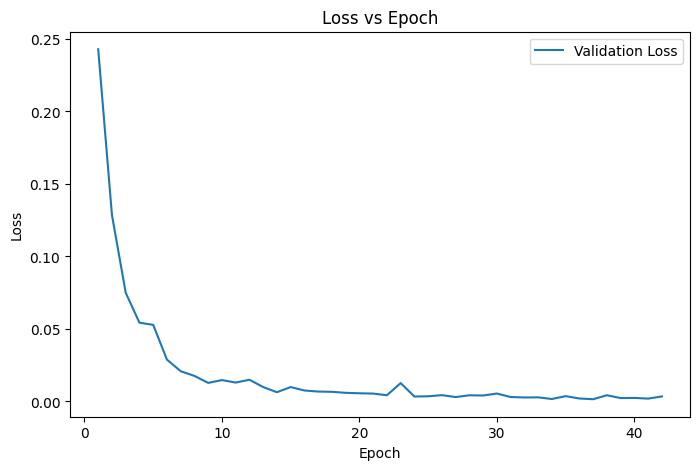

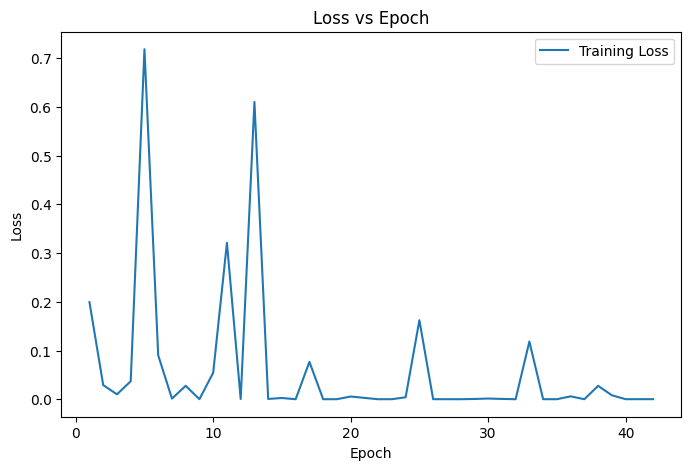

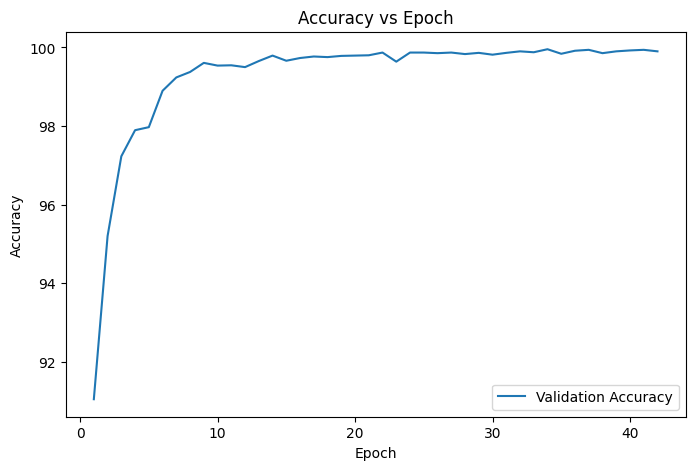

In [25]:
lossdf = pd.read_csv("new_mobilenetv3_large_loss.csv", engine="pyarrow")

plt.figure(figsize=(8, 5))
plt.plot(lossdf["epoch"], lossdf["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(lossdf["epoch"], lossdf["train_loss"], label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(lossdf["epoch"], lossdf["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch")
plt.legend()
plt.show()

In [8]:

# # Import the timm pth models
# model = torch.load("mobilenetv3_large.pth")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
# Create an instance of the model
model = timm.create_model('mobilenetv3_large_100', num_classes=2, drop_rate=0.2).to(device)

# Load the saved state dictionary into the model
model.load_state_dict(torch.load('Models/new_mobilenetv3_large.pth', map_location=device))

correct = 0
total = 0
all_predicted = []
all_labels = []
counter = 0

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        counter += 1
        if counter % 5000 == 0:
            print(f"Completed {counter} batches")

accuracy = 100 * correct / total

print("Done testing")



Device: cuda
Done testing




Accuracy on the test dataset: 99.876591%

Confusion Matrix:
 [[ 2872    10]
 [    6 10077]]


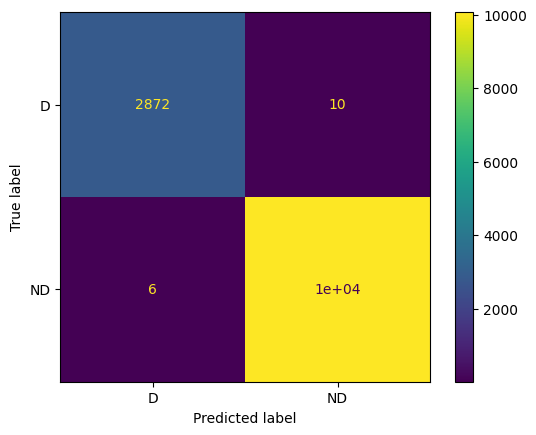


Manual Precision: 0.9990086249628234
Manual Recall: 0.9994049390062482

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2882
           1       1.00      1.00      1.00     10083

    accuracy                           1.00     12965
   macro avg       1.00      1.00      1.00     12965
weighted avg       1.00      1.00      1.00     12965



AUC-ROC Score: 0.997968


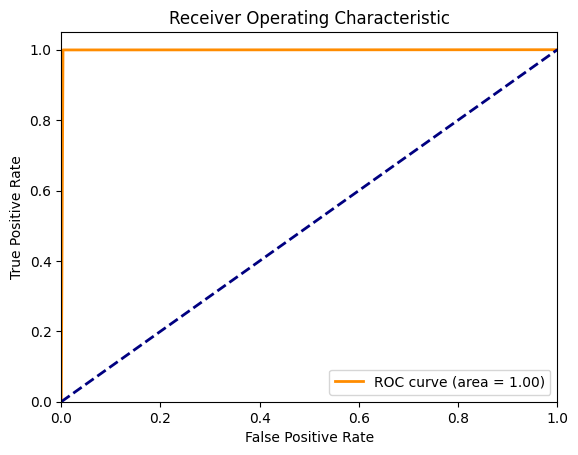

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, classification_report, auc, roc_curve

print('\n\nAccuracy on the test dataset: {:.6f}%'.format(accuracy), end="\n\n")

# Calculate the confusion matrix
confusion = confusion_matrix(all_labels, all_predicted)
print("Confusion Matrix:\n", confusion)
cm = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=["D", "ND"])
cm.plot()
plt.show()
print(cm, end='\n\n')

# Generate precision-recall metrics
precision_manual = precision_score(all_labels, all_predicted)
recall_manual = recall_score(all_labels, all_predicted)

print("Manual Precision:", precision_manual)
print("Manual Recall:", recall_manual, end="\n\n")

# Generate classification report
report = classification_report(all_labels, all_predicted)
print("Classification Report:\n", report, end='\n\n')

# Calculate ROC curve and AUC-ROC score
# fpr, tpr, thresholds = roc_curve(all_labels, outputs.cpu().numpy()[:, 1].astype(float))
fpr, tpr, thresholds = roc_curve(y_true=all_labels, y_score=all_predicted)
roc_auc = auc(fpr, tpr)
print("\nAUC-ROC Score: {:.6f}".format(roc_auc))

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Test on Augmented Test Dataset

In [9]:

# # Import the timm pth models
# model = torch.load("mobilenetv3_large.pth")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
# Create an instance of the model
model = timm.create_model('mobilenetv3_large_100', num_classes=2, drop_rate=0.2).to(device)

# Load the saved state dictionary into the model
model.load_state_dict(torch.load('Models/new_mobilenetv3_large.pth', map_location=device))

correct = 0
total = 0
all_predicted = []
all_labels = []
counter = 0

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for inputs, labels in test_loader2:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        counter += 1
        if counter % 5000 == 0:
            print(f"Completed {counter} batches")

accuracy = 100 * correct / total

print("Done testing")



Device: cuda
Done testing




Accuracy on the test dataset: 99.922863%

Confusion Matrix:
 [[6473    9]
 [   1 6481]]


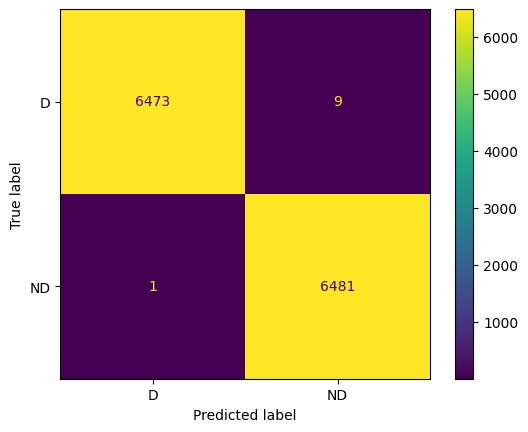


Manual Precision: 0.998613251155624
Manual Recall: 0.9998457266275841

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6482
           1       1.00      1.00      1.00      6482

    accuracy                           1.00     12964
   macro avg       1.00      1.00      1.00     12964
weighted avg       1.00      1.00      1.00     12964



AUC-ROC Score: 0.999229


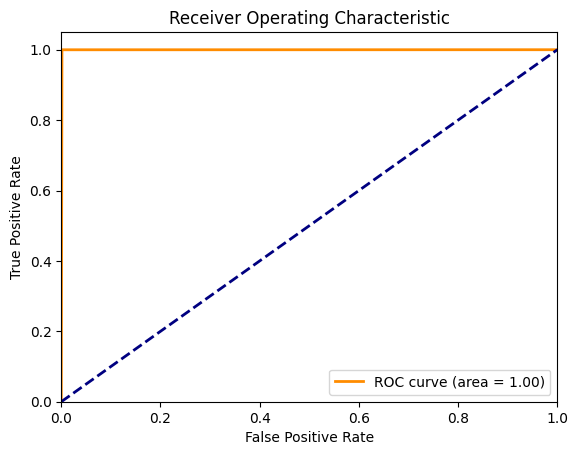

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, classification_report, auc, roc_curve

print('\n\nAccuracy on the test dataset: {:.6f}%'.format(accuracy), end="\n\n")

# Calculate the confusion matrix
confusion = confusion_matrix(all_labels, all_predicted)
print("Confusion Matrix:\n", confusion)
cm = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=["D", "ND"])
cm.plot()
plt.show()
print(cm, end='\n\n')

# Generate precision-recall metrics
precision_manual = precision_score(all_labels, all_predicted)
recall_manual = recall_score(all_labels, all_predicted)

print("Manual Precision:", precision_manual)
print("Manual Recall:", recall_manual, end="\n\n")

# Generate classification report
report = classification_report(all_labels, all_predicted)
print("Classification Report:\n", report, end='\n\n')

# Calculate ROC curve and AUC-ROC score
# fpr, tpr, thresholds = roc_curve(all_labels, outputs.cpu().numpy()[:, 1].astype(float))
fpr, tpr, thresholds = roc_curve(y_true=all_labels, y_score=all_predicted)
roc_auc = auc(fpr, tpr)
print("\nAUC-ROC Score: {:.6f}".format(roc_auc))

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()